<div align = "center">

# **Modelos GARCH**

</div>

## Librerias

In [2]:
import pandas as pd
import statsmodels
import arch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

from sklearn.model_selection import train_test_split
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

## Data

In [3]:
sp500 = pd.read_csv("../data/input/sp500.csv")["Close"]
retornos = np.log(sp500 / sp500.shift(1)) * 100
retornos = retornos[1:]
historica = retornos.rolling(window=7).std()
implicada = pd.read_csv("../data/input/vix.csv")["Close"]

historica = historica[1:]
implicada = implicada[1:]

FileNotFoundError: [Errno 2] No such file or directory: '../data/input/sp500.csv'

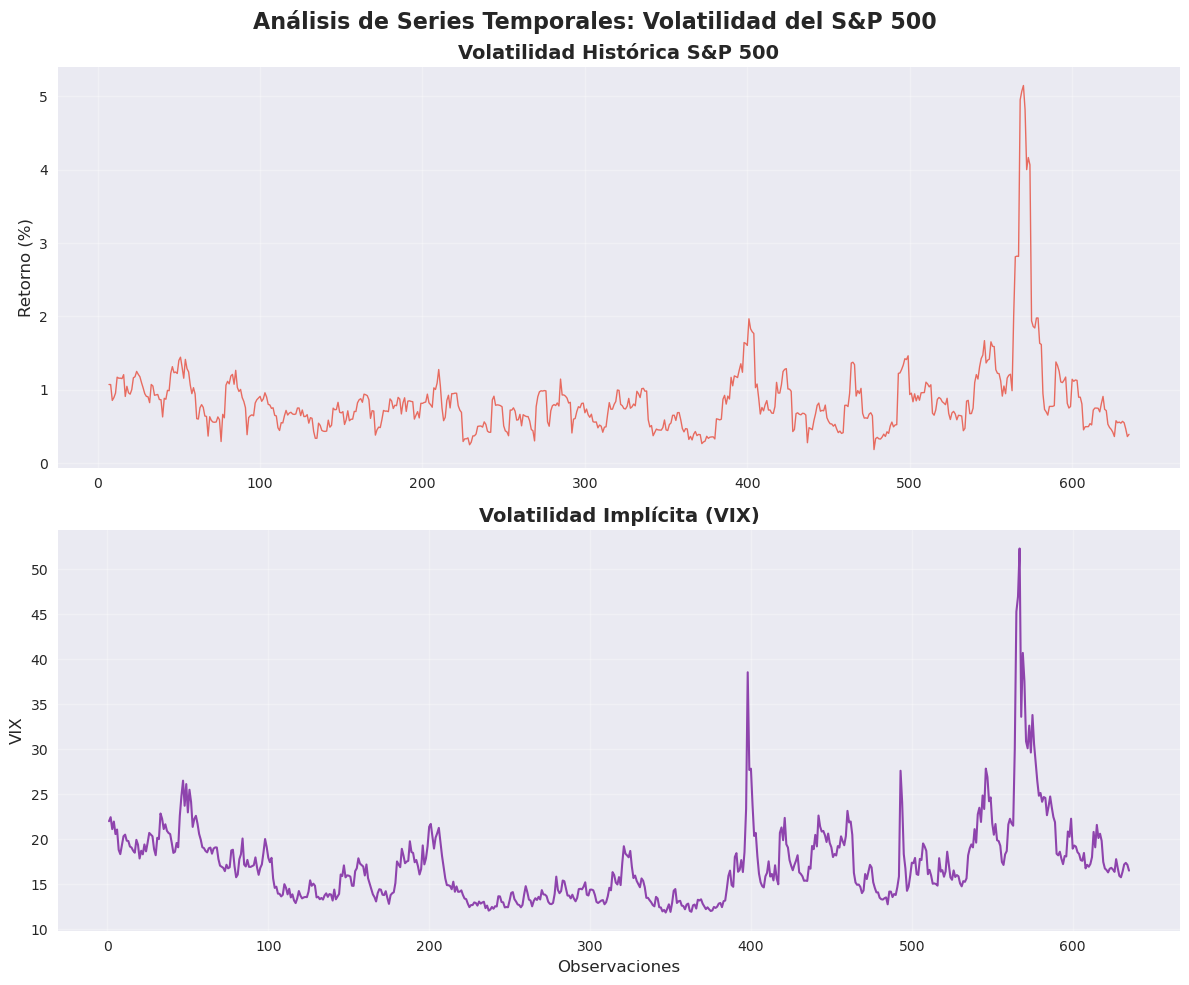

In [ ]:
# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Crear figura con subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Análisis de Series Temporales: Volatilidad del S&P 500', fontsize=16, fontweight='bold')

# Gráfico 2: Volatilidad Histórica (Retornos)
axes[0].plot(historica, linewidth=1, color='#E74C3C', alpha=0.8)
axes[0].set_title('Volatilidad Histórica S&P 500', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Retorno (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(labelsize=10)

# Gráfico 3: Volatilidad Implícita (VIX)
axes[1].plot(implicada, linewidth=1.5, color='#8E44AD')
axes[1].set_title('Volatilidad Implícita (VIX)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('VIX', fontsize=12)
axes[1].set_xlabel('Observaciones', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('../images/series_temporales.png', dpi=300, bbox_inches='tight')
plt.show()

## Funcion de autocorrelacio

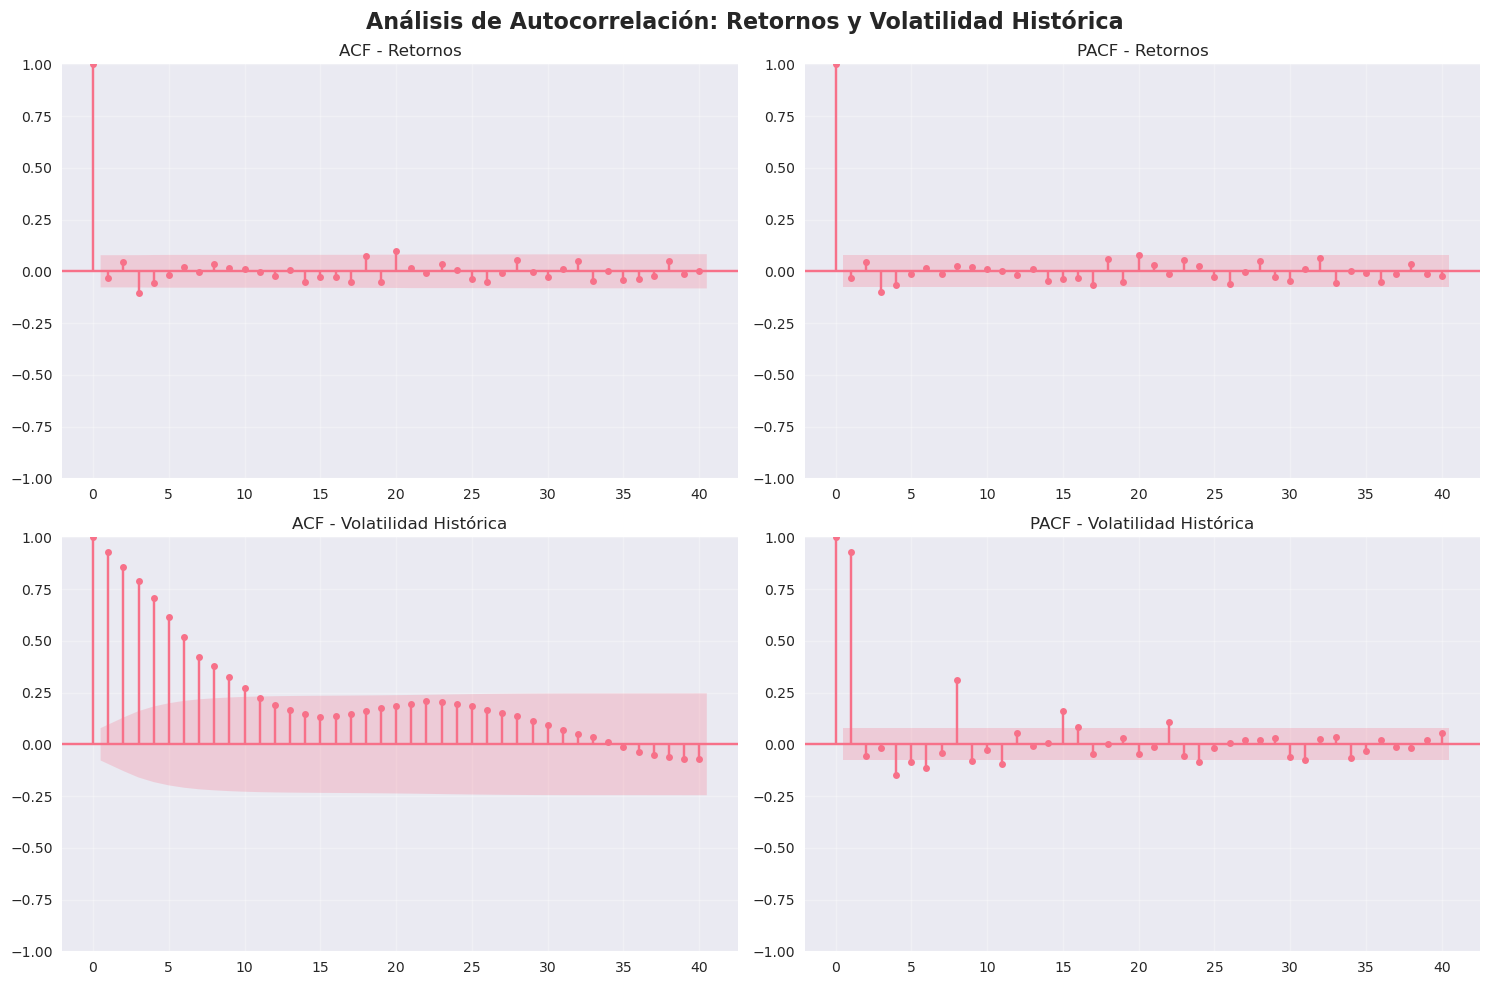

In [ ]:
  fig, axes = plt.subplots(2, 2, figsize=(15, 10))
  fig.suptitle('Análisis de Autocorrelación: Retornos y Volatilidad Histórica', fontsize=16,
  fontweight='bold')

  # ACF de retornos
  plot_acf(retornos, ax=axes[0,0], lags=40, title='ACF - Retornos')
  axes[0,0].grid(True, alpha=0.3)

  # PACF de retornos
  plot_pacf(retornos, ax=axes[0,1], lags=40, title='PACF - Retornos')
  axes[0,1].grid(True, alpha=0.3)

  # ACF de volatilidad histórica
  plot_acf(historica.dropna(), ax=axes[1,0], lags=40, title='ACF - Volatilidad Histórica')
  axes[1,0].grid(True, alpha=0.3)

  # PACF de volatilidad histórica
  plot_pacf(historica.dropna(), ax=axes[1,1], lags=40, title='PACF - Volatilidad Histórica')
  axes[1,1].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig('../images/acf_y_pacf.png', dpi=300, bbox_inches='tight')
  plt.show()

## Modelado GARCH

In [ ]:
# Preparar los datos para el modelo GARCH
# Eliminar valores NaN y convertir a array
volatilidad_data = historica.dropna()
print(f"Datos disponibles para modelado: {len(volatilidad_data)} observaciones")

# División en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(volatilidad_data))
train_data = volatilidad_data[:train_size]
test_data = volatilidad_data[train_size:]

print(f"Conjunto de entrenamiento: {len(train_data)} observaciones")
print(f"Conjunto de prueba: {len(test_data)} observaciones")

Datos disponibles para modelado: 629 observaciones
Conjunto de entrenamiento: 503 observaciones
Conjunto de prueba: 126 observaciones


In [ ]:
# Ajustar modelo GARCH(1,10) 
# El modelo GARCH(p,q) donde p=1 (términos ARCH) y q=10 (términos GARCH)
modelo_garch = arch_model(train_data, vol='GARCH', p=1, q=10, mean='Constant', dist='normal')

# Ajustar el modelo
resultado_garch = modelo_garch.fit(disp='off')

Ajustando modelo GARCH(1,10)...
Modelo ajustado exitosamente!
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                48.3274
Distribution:                  Normal   AIC:                          -70.6548
Method:            Maximum Likelihood   BIC:                          -15.7871
                                        No. Observations:                  503
Date:                Sun, Jul 20 2025   Df Residuals:                      502
Time:                        18:17:29   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu      

In [ ]:
# Generar predicciones del modelo GARCH
# Predicciones para el conjunto de entrenamiento (ajuste)
predicciones_train = resultado_garch.conditional_volatility

# Predicciones fuera de muestra para el conjunto de prueba
predicciones_test = resultado_garch.forecast(horizon=len(test_data))
volatilidad_predicha_test = np.sqrt(predicciones_test.variance.dropna().values.flatten())

# Combinar todas las predicciones
predicciones_completas = np.concatenate([predicciones_train, volatilidad_predicha_test])

print(f"Predicciones de entrenamiento: {len(predicciones_train)}")
print(f"Predicciones de prueba: {len(volatilidad_predicha_test)}")
print(f"Total de predicciones: {len(predicciones_completas)}")
print(f"Datos originales: {len(volatilidad_data)}")

Predicciones de entrenamiento: 503
Predicciones de prueba: 126
Total de predicciones: 629
Datos originales: 629


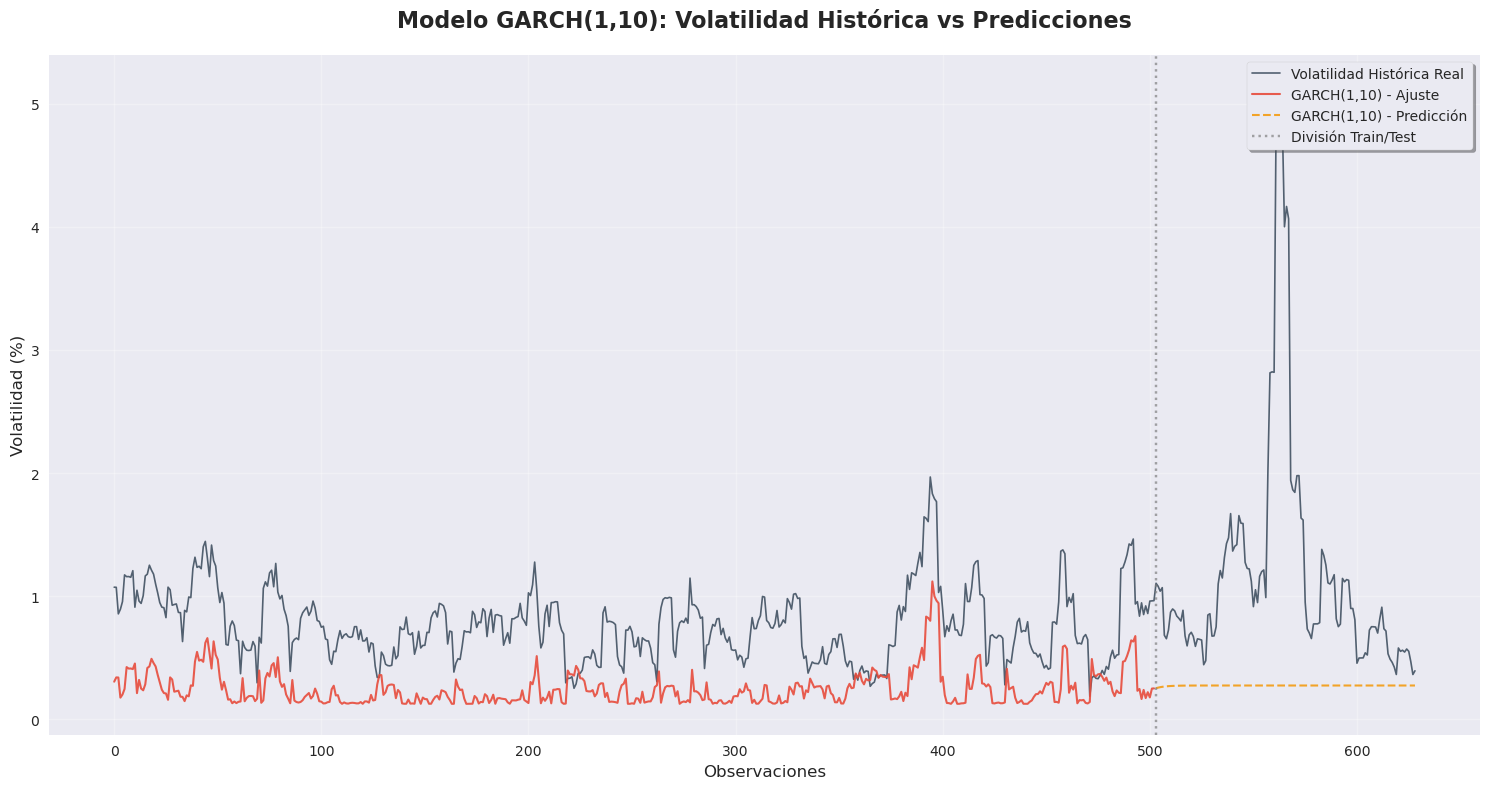


=== Métricas del Modelo GARCH(1,10) ===
MSE en conjunto de prueba: 1.762366
MAE en conjunto de prueba: 0.917052
RMSE en conjunto de prueba: 1.327541
Correlación (Test): 0.0663


In [ ]:
# Crear gráfica comparando serie real vs predicciones GARCH(1,10)
plt.figure(figsize=(15, 8))

# Crear índices para la gráfica
indices = np.arange(len(volatilidad_data))
indices_train = indices[:len(predicciones_train)]
indices_test = indices[len(predicciones_train):]

# Graficar serie real
plt.plot(indices, volatilidad_data.values, label='Volatilidad Histórica Real', 
         linewidth=1.2, color='#2C3E50', alpha=0.8)

# Graficar predicciones de entrenamiento
plt.plot(indices_train, predicciones_train, label='GARCH(1,10) - Ajuste', 
         linewidth=1.5, color='#E74C3C', alpha=0.9)

# Graficar predicciones de prueba
plt.plot(indices_test, volatilidad_predicha_test, label='GARCH(1,10) - Predicción', 
         linewidth=1.5, color='#F39C12', alpha=0.9, linestyle='--')

# Añadir línea vertical para separar entrenamiento y prueba
plt.axvline(x=len(predicciones_train), color='gray', linestyle=':', alpha=0.7, 
            label='División Train/Test')

# Configurar la gráfica
plt.title('Modelo GARCH(1,10): Volatilidad Histórica vs Predicciones', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Observaciones', fontsize=12)
plt.ylabel('Volatilidad (%)', fontsize=12)
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Guardar la gráfica
plt.savefig('../images/garch_modelo_volatilidad_historica.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas del modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Error en conjunto de prueba
mse_test = mean_squared_error(test_data, volatilidad_predicha_test)
mae_test = mean_absolute_error(test_data, volatilidad_predicha_test)

print(f"\n=== Métricas del Modelo GARCH(1,10) ===")
print(f"MSE en conjunto de prueba: {mse_test:.6f}")
print(f"MAE en conjunto de prueba: {mae_test:.6f}")
print(f"RMSE en conjunto de prueba: {np.sqrt(mse_test):.6f}")

# Correlación entre predicciones y valores reales
correlacion_test = np.corrcoef(test_data, volatilidad_predicha_test)[0, 1]
print(f"Correlación (Test): {correlacion_test:.4f}")